In [31]:
import requests as requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic

In [30]:
def get_pageview_data(articles, years, lang, save_csv=True):
    search_url = f'http://petermeissner.de:8880/article/exact/{lang}/'
    final_list = []
    
    for article in articles:
        article_no_spaces = re.sub(r'\s','_', article)
        request = requests.get(search_url + article_no_spaces).json()
        if request['status'] != 'ok':
            print(f'Problem fetching data for article {article}')
            continue
        data = request['data']
        for elem in data:
            year = elem['year']
            if str(year) in years:
                timestamps = pd.date_range(f'01-01-{year}', f'31-12-{year}')
                page_views = elem['page_view_count'].split(',')
                assert len(timestamps) == len(page_views)
                final_list += list(zip(timestamps, [article] * len(timestamps), [lang] * len(timestamps), page_views)) 
    df = pd.DataFrame(final_list, columns=['date', 'article','language', 'pageviews'])
    if save_csv:
        df.to_csv(f'data/data_{lang}.csv')
    return df
    

In [3]:
terrorism_articles = ['abu_sayyaf', 'afghanistan', 'agro', 'al-qaeda',
       'al-qaeda_in_the_arabian_peninsula',
       'al-qaeda_in_the_islamic_maghreb', 'al-shabaab',
       'ammonium_nitrate', 'attack', 'biological_weapon', 'car_bomb',
       'chemical_weapon', 'conventional_weapon', 'dirty_bomb',
       'eco-terrorism', 'environmental_terrorism',
       'euskadi_ta_askatasuna', 'extremism', 'farc', 'fundamentalism',
       'hamas', 'hezbollah', 'improvised_explosive_device', 'iran',
       'iraq', 'irish_republican_army', 'islamist', 'jihad',
       'nationalism', 'nigeria', 'nuclear', 'nuclear_enrichment',
       'pakistan', 'palestine_liberation_front', 'pirates', 'plo',
       'political_radicalism', 'recruitment', 'somalia', 'suicide_attack',
       'suicide_bomber', 'taliban', 'tamil_tigers',
       'tehrik-i-taliban_pakistan', 'terror', 'terrorism',
       'weapons-grade', 'yemen']
terrorism_articles_de = ['al-Qaida','Terrorismus', 'Terror (Begriffsklärung)', 'Attack', 'Irak', 'Afghanistan',
                        'Iran', 'Pakistan', 'Agroterrorismus', 'Ökoterrorismus','Hochangereichertes Uran',"Chemische Waffe", "Ammoniumnitrat",
                        "Unkonventionelle Spreng- und Brandvorrichtung", "Abu Sajaf", "Hamas",
                        "FARC-EP", "Geschichte der Irisch-Republikanischen Armee", "Euskadi Ta Askatasuna" , "Hisbollah",
                        "Liberation Tigers of Tamil Eelam", "Palästinensische Befreiungsorganisation", "Palästinensische Befreiungsfront", 
                        "Autobombe", "Dschihad", "Taliban",
                        'Islamismus', 'Fundamentalismus', 'Personalbeschaffung', 'Nationalismus', 'Al-Shabaab',
                        'Radikalismus', 'Nigeria', 'Somalia', 'Extremismus', 'Piraterie', 'Jemen', 'Tehrik-i-Taliban Pakistan',
                        'Al-Qaida im Maghreb', 'Al-Qaida auf der Arabischen Halbinsel', 'Selbstmordattentat']

In [4]:
# articles = get_pageview_data(terrorism_articles, ['2012', '2013','2014','2015', '2016'], 'de')

In [66]:
data = pd.read_csv('data/data_en.csv', parse_dates=['date'], index_col=0)

In [67]:
reference = pd.read_csv('data/terrorism_data.csv')

In [68]:
testing_ref_data = reference.set_index(['date','article']).loc[:, 'views'].astype(int).sort_index(level=[0,1])

In [69]:
test = articles.loc[articles.date.isin(reference.date)].set_index(['date','article']).sort_index(level=[0,1])['pageviews'].astype(int)

NameError: name 'articles' is not defined

In [70]:
import numpy as np
np.count_nonzero((test.values == testing_ref_data.values)) == len(test)

NameError: name 'test' is not defined

In [71]:
# drop the language column
data = data.drop('language', axis=1)

# filter all rows corresponding to the article about Hamas, as it represents an outlier in the data
data = data[data.article != 'hamas']

print(len(data.article.unique())) # expect 47

47


In [72]:
# Helper function, performs all the necessary operations to prepare the data for ITS regression

def prepare_data_for_regression(data):
    pageviews_per_month = data.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
    # june 2013 and its index, where the months are counted from 1 to 32
    june_2013 = pd.to_datetime('2013-06-30')
    june_2013_index = 18 

    # prepare columns for the regression

    # intervention is an indicator function, which takes the value 1 for rows after June 2013
    pageviews_per_month['intervention'] = (pageviews_per_month.date >= june_2013).astype(int)

    # time is the sequence [1,2,..,32] as we have 32 months
    pageviews_per_month ['time'] = range(1,len(pageviews_per_month) + 1)

    # post_slope is 0 before June 2013, then 1,2,.. starting June 2013
    pageviews_per_month['post_slope'] = (pageviews_per_month['time'] - june_2013_index + 1) * \
                                         pageviews_per_month['intervention']
    
    return pageviews_per_month

In [73]:
reg_data = prepare_data_for_regression(data)

In [74]:
import statsmodels.formula.api as smf

model = smf.ols(formula='pageviews ~ time + C(intervention) + post_slope ', data=reg_data)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     18.98
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           4.79e-08
Time:                        20:47:28   Log-Likelihood:                -700.56
No. Observations:                  48   AIC:                             1409.
Df Residuals:                      44   BIC:                             1417.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.391e+06    2.8e+05      8.552      0.000    1.83e+06    2.95e+06
C(intervention)[T.1] -1.142e+06   3.27e+05     -3.498      0.001    -1.8e+06   -4.84e+05
time                  6.119e+04   2.73e+04      2.243      0.030    6209.037    1.16e+05
post_slope           -9.016e+04   2.94e+04     -3.063      0.004   -1.49e+05   -3.08e+04
==============================================================================
Omnibus:                       16.671   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.631
Skew:                          -1.316   Prob(JB):                     5.46e-05
Kurtosis:                       4.698   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
# We compute the predictions and 95% CIs for the two models
preds = res.get_prediction(reg_data)\
                .summary_frame(alpha=0.05)[['mean','mean_ci_lower', 'mean_ci_upper']]

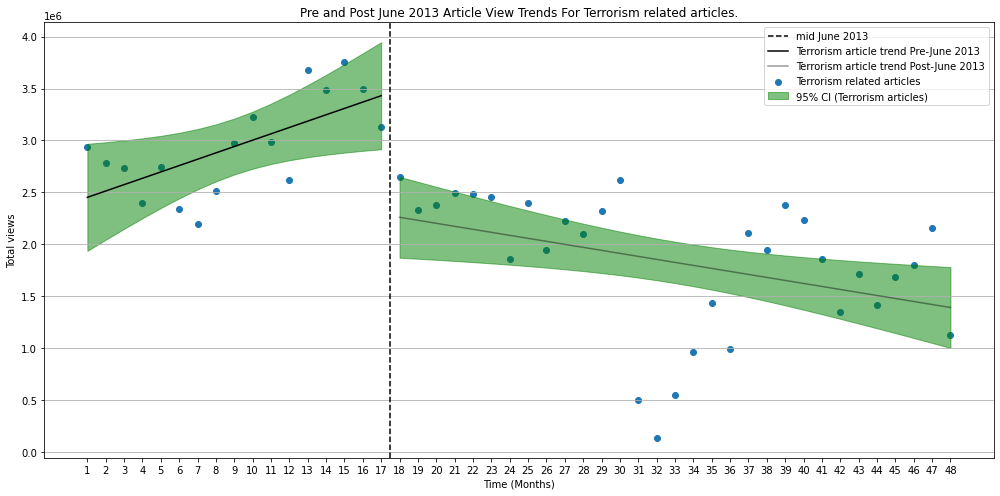

In [76]:
plt.figure(figsize=(14,7)) 

# some useful indexes (in the dataframe), ticks, etc
xticks = range(1, preds.shape[0] + 1)
start_index = 1
before_interruption_index = 17
after_interruption_index = 18
end_index = 48
# equivalent indexes in the dataframe
points_index = [start_index - 1, before_interruption_index - 1, after_interruption_index - 1, end_index - 1] 
# useful mask, when plotting CIs
ci_mask_before = np.array(xticks) <= before_interruption_index


# plot the article views
plt.scatter(data=reg_data, x='time', y='pageviews', label='Terrorism related articles')
# plt.scatter(data=pageviews_domestic,x='time', y='views', marker='X', label='Security related articles')

# Add ticks and a line representing the period just before the intervention
plt.xticks(xticks)
plt.axvline(x=after_interruption_index - 0.5, c='black', label='mid June 2013',ls='--')

# Terrorism lines
p1, p2, p3, p4 = preds.loc[points_index, 'mean']
plt.plot ([start_index, before_interruption_index], [p1, p2] , c='black', label= 'Terrorism article trend Pre-June 2013')
plt.plot ([after_interruption_index, end_index], [p3, p4] ,c='black', alpha=0.4, label= 'Terrorism article trend Post-June 2013')
plt.fill_between(x=xticks, y1=preds['mean_ci_lower'], y2=preds['mean_ci_upper'],color='g', where=ci_mask_before, alpha=0.5,\
                 label='95% CI (Terrorism articles)')
plt.fill_between(x=xticks, y1=preds['mean_ci_lower'], y2=preds['mean_ci_upper'],color='g', where=~ci_mask_before, alpha=0.5)

# domestic security lines
# p1, p2, p3, p4 = pred_domestic.loc[points_index, 'mean']
# plt.plot ([start_index, before_interruption_index], [p1, p2] , c='brown', label= 'Security article trend Pre-June 2013')
# plt.plot ([after_interruption_index, end_index], [p3, p4] ,c='brown', alpha=0.4, label= 'Security article trend Post-June 2013')
# plt.fill_between(x=xticks, y1=pred_domestic['mean_ci_lower'], y2=pred_domestic['mean_ci_upper'],color='y', where=ci_mask_before, alpha=0.5, \
#                  label='95% CI (Security articles)')
# plt.fill_between(x=xticks, y1=pred_domestic['mean_ci_lower'], y2=pred_domestic['mean_ci_upper'],color='y', where=~ci_mask_before, alpha=0.5)


# Add Title, labels and legend 
plt.title ("Pre and Post June 2013 Article View Trends For Terrorism related articles.")
plt.xlabel("Time (Months)")
plt.ylabel("Total views")
plt.legend()

# Keep only the horizontal grid
plt.grid (False, axis='x')
plt.grid (True, axis='y')
plt.tight_layout()

plt.show()


In [84]:
reg_data.iloc[31]

date            2014-08-31 00:00:00
pageviews                    133212
intervention                      1
time                             32
post_slope                       15
Name: 31, dtype: object

In [81]:
diagnostic.kstest_normal(reg_data.loc[reg_data.intervention == 1,'pageviews'].values,'norm')

(0.14238103221921927, 0.1123665736357827)